# Plotting the data in a `.braidz` file

Once you have obtained a `.braidz` file, you might want to plot the 2D time series, the Kalman estimates or the 3D time series.

To do this, we first need to import a few libraries.

In [1]:
import zipfile
import urllib.request # requires Python 3
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the data
First, we load the file we want to analyze.

We can either load a local file, or load it from an url.
Let's define a function that can differentiate between an url and a local path, and load the object:

In [2]:
def open_filename_or_url(filename_or_url):
    parsed = urllib.parse.urlparse(filename_or_url)
    is_windows_drive = len(parsed.scheme) == 1
    if is_windows_drive or parsed.scheme=='':
        # no scheme, so this is a filename.
        fileobj_with_seek = open(filename_or_url,mode='rb')
    else:
        # is url
        req = urllib.request.Request(filename_or_url, headers={'User-Agent' : "IPYNB"}) 
        fileobj = urllib.request.urlopen(req)
        fileobj_with_seek = io.BytesIO(fileobj.read())
    return fileobj_with_seek


For now, we use a link to the file `20201112_133722.braidz` and load this file using the previously defined function.
If you want to load from an url, please use the structure `scheme://netloc/path` in order for it to be parsed correctly.

In [3]:
filename_or_url = "http://strawlab-cdn.com/assets/20201112_133722.braidz"

fileobj = open_filename_or_url(filename_or_url)

Now open this file and read out the relevant components.

In [4]:
with zipfile.ZipFile(file=fileobj, mode='r') as archive:
    cam_info_df = pd.read_csv(
        archive.open('cam_info.csv.gz'),
        comment="#",
        compression='gzip')

    camn2camid = {}
    for i, row in cam_info_df.iterrows():
        camn2camid[row['camn']] = row['cam_id']

    cam_ids = list(cam_info_df['cam_id'].values)
    cam_ids.sort()
    data2d_distorted_df = pd.read_csv(
        archive.open('data2d_distorted.csv.gz'),
        comment="#",
        compression='gzip')

    kalman_df = pd.read_csv(
        archive.open('kalman_estimates.csv.gz'),
        comment="#",
        compression='gzip')

## Plotting the 2D time series
Plot the 2D trajectories over time per camera.

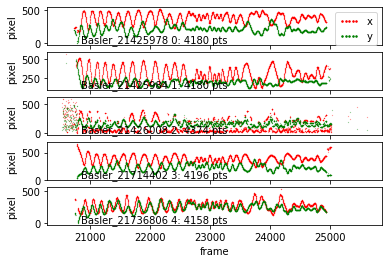

In [12]:
fig, axes = plt.subplots(nrows=len(cam_ids),sharex=True, squeeze=False)
assert axes.shape[1]==1
axes = axes[:,0]

for camn, gdf in data2d_distorted_df.groupby('camn'):
    camid = camn2camid[camn]
    idx = cam_ids.index(camid)
    ax = axes[idx]

    cam_id_n_valid = np.sum(~np.isnan(gdf['x']))

    ax.plot(gdf['frame'], gdf['x'], 'r.', ms=0.3, label='x')
    ax.plot(gdf['frame'], gdf['y'], 'g.', ms=0.3, label='y')

    ax.text(0.1,0,'%s %s: %d pts'%(camid,camn,cam_id_n_valid),
            horizontalalignment='left',
            verticalalignment='bottom',
            transform = ax.transAxes,
            )
    ax.set_ylabel('pixel')

axes[-1].set_xlabel('frame')
axes[0].legend(loc='upper right', numpoints=5, markerscale=10);


## Plotting the Kalman estimates

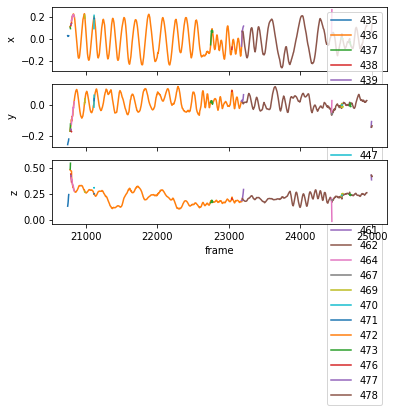

In [9]:
dimnames = ['x','y','z']
fig, axes = plt.subplots(nrows=len(dimnames),sharex=True)

for ax,dimname in zip(axes,dimnames):
    for obj_id, gdf in kalman_df.groupby('obj_id'):
        ax.plot(gdf['frame'], gdf[dimname], '-', label=str(obj_id))
    ax.set_ylabel(dimname)

axes[-1].set_xlabel('frame')
axes[0].legend(loc='upper right');

## Plotting the 3D time series

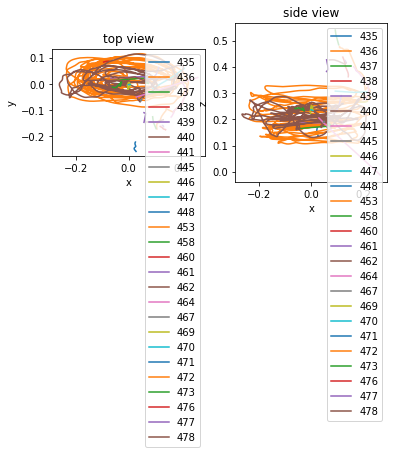

In [14]:
fig, axes = plt.subplots(ncols=2,nrows=1,sharex=True)

ax = axes[0]
for obj_id, gdf in kalman_df.groupby('obj_id'):
    ax.plot(gdf['x'], gdf['y'], '-', label=str(obj_id))
ax.set_title("top view")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.legend(loc='upper right')

ax = axes[1]
for obj_id, gdf in kalman_df.groupby('obj_id'):
    ax.plot(gdf['x'], gdf['z'], '-', label=str(obj_id))
ax.set_title("side view")
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_aspect('equal')
ax.legend(loc='upper right');